## Task 4: Building predictive model

- Objective: to predict claim severity prediction. Done to predict the Total Claim amount. 

In [1]:
import os
import sys

system_path = os.path.abspath('..')
if system_path not in sys.path:
    sys.path.append(system_path)

%load_ext autoreload
%autoreload 2

In [2]:
from src.predictive_modeling import InsuranceRiskModel
from src.eda_analysis import InsuranceEDA
eda = InsuranceEDA()
modeling = InsuranceRiskModel()

In [4]:
data = eda.load_data('../data/insurance_data.parquet')
data

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000093,31520,389,2015-04-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000094,31520,389,2015-06-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000095,31520,389,2015-08-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000096,31519,389,2014-07-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Passenger Liability,Passenger Liability,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,2.315000,0.0


In [5]:
eda.check_missing_values()


--------------------------------Missing Values Analysis--------------------------------
Total number of columns with missing values: 22

Missing values summary:


,Missing Count,Missing Percentage
NumberOfVehiclesInFleet,1000098,100.000000
CrossBorder,999400,99.930207
CustomValueEstimate,779642,77.956560
Rebuilt,641901,64.183810
Converted,641901,64.183810
WrittenOff,641901,64.183810
NewVehicle,153295,15.327998
Bank,145961,14.594670
AccountType,40232,4.022806
Gender,9536,0.953507


In [7]:
# Remove columns with more than 5% missing values
missing_threshold = 5.0
missing_summary = eda.check_missing_values()

# Get columns with more than 5% missing values
columns_to_remove = missing_summary[missing_summary['Missing Percentage'] > missing_threshold].index.tolist()

print(f"Columns to remove (missing > {missing_threshold}%):")
for col in columns_to_remove:
    print(f"- {col}")

# Remove the columns from the dataset
data_cleaned = data.drop(columns=columns_to_remove)

print(f"\nOriginal dataset shape: {data.shape}")
print(f"Cleaned dataset shape: {data_cleaned.shape}")
print(f"Removed {len(columns_to_remove)} columns")

# Update the data in the EDA object
eda.data = data_cleaned



--------------------------------Missing Values Analysis--------------------------------
Total number of columns with missing values: 14

Missing values summary:
Columns to remove (missing > 5.0%):

Original dataset shape: (1000098, 52)
Cleaned dataset shape: (1000098, 52)
Removed 0 columns


In [9]:
# Create a subset of data where claims > 0 for modeling
claims_data = data_cleaned[data_cleaned['TotalClaims'] > 0].copy()
claims_data.to_parquet('../data/claims_data.parquet')
print(f"shape of claims_data: {claims_data.shape}")

shape of claims_data: (2788, 52)


In [10]:
claims_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2788 entries, 203 to 999923
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   UnderwrittenCoverID       2788 non-null   int64         
 1   PolicyID                  2788 non-null   int64         
 2   TransactionMonth          2788 non-null   datetime64[ns]
 3   IsVATRegistered           2788 non-null   bool          
 4   Citizenship               2788 non-null   object        
 5   LegalType                 2788 non-null   object        
 6   Title                     2788 non-null   object        
 7   Language                  2788 non-null   object        
 8   Bank                      2571 non-null   object        
 9   AccountType               2710 non-null   object        
 10  MaritalStatus             2773 non-null   object        
 11  Gender                    2774 non-null   object        
 12  Country              

Data preparation 

In [11]:
preprocessed_data = modeling.prepare_data(claims_data, 'TotalClaims', test_size=0.2, random_state=42, task_type='classification')

Preparing data for classification task...
Original dataset shape: (2788, 52)
Engineering features...
Feature engineering complete. New shape: (2788, 61)
Handling missing values...
Missing values handled.
Numeric features: 20
Categorical features: 35
Training set shape: (2230, 60)
Test set shape: (558, 60)


In [12]:
modeling.build_models()

Built 3 models for regression task


In [13]:
X_train, y_train, X_test, y_test = preprocessed_data

In [14]:
# Check for any remaining datetime columns that might be causing the error
print("Checking for datetime columns in X_train:")
datetime_columns = X_train.select_dtypes(include=['datetime64']).columns.tolist()
print(f"Datetime columns found: {datetime_columns}")

print("\nChecking for datetime columns in X_test:")
datetime_columns_test = y_train.select_dtypes(include=['datetime64']).columns.tolist()
print(f"Datetime columns found: {datetime_columns_test}")

# Convert any remaining datetime columns to string format
if datetime_columns:
    for col in datetime_columns:
        X_train[col] = X_train[col].dt.strftime('%Y-%m-%d')
        print(f"Converted {col} in X_train to string format")

if datetime_columns_test:
    for col in datetime_columns_test:
        y_train[col] = y_train[col].dt.strftime('%Y-%m-%d')
        print(f"Converted {col} in y_train to string format")

# Verify all columns are now non-datetime
print("\nVerifying data types after conversion:")
print("X_train dtypes:")
print(X_train.dtypes)
print("\nX_test dtypes:")
print(y_train.dtypes)

# Now try training the models again
print("\nAttempting to train models again...")
models = modeling.train_models(X_train, X_test)


Checking for datetime columns in X_train:
Datetime columns found: ['TransactionMonth']

Checking for datetime columns in X_test:
Datetime columns found: ['TransactionMonth']
Converted TransactionMonth in X_train to string format
Converted TransactionMonth in y_train to string format

Verifying data types after conversion:
X_train dtypes:
UnderwrittenCoverID           int64
PolicyID                      int64
TransactionMonth             object
IsVATRegistered                bool
Citizenship                  object
LegalType                    object
Title                        object
Language                     object
Bank                         object
AccountType                  object
MaritalStatus                object
Gender                       object
Country                      object
Province                     object
PostalCode                    int64
MainCrestaZone               object
SubCrestaZone                object
ItemType                     object
mmcode      

In [16]:
evaluate = modeling.evaluate_models(models, y_train, y_test)

Evaluating models...
linear_regression: RMSE=0.0000, R²=1.0000, MAE=0.0000
random_forest: RMSE=0.0000, R²=1.0000, MAE=0.0000
xgboost: RMSE=0.0000, R²=1.0000, MAE=0.0000

Best model: linear_regression


In [22]:
result, best_model = evaluate
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['UnderwrittenCoverID', 'PolicyID', 'PostalCode', 'mmcode',
       'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts',
       'NumberOfDoors', 'CustomValueEstimate', 'NumberOfVehiclesInFleet',
       'Su...
       'SubCrestaZone', 'ItemType', 'VehicleType', 'make', 'Model', 'bodytype',
       'VehicleIntroDate', 'AlarmImmobiliser', 'TrackingDevice',
       'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt',
       'Converted', 'CrossBorder', 'TermFrequency', 'ExcessSelected',
       'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product',
       'StatutoryClass', 'StatutoryRiskType'],
      dtype='object'))])),
                ('model', LinearRegression())])

Analyzing feature importance for the best model...
Analyzing feature importance with SHAP...


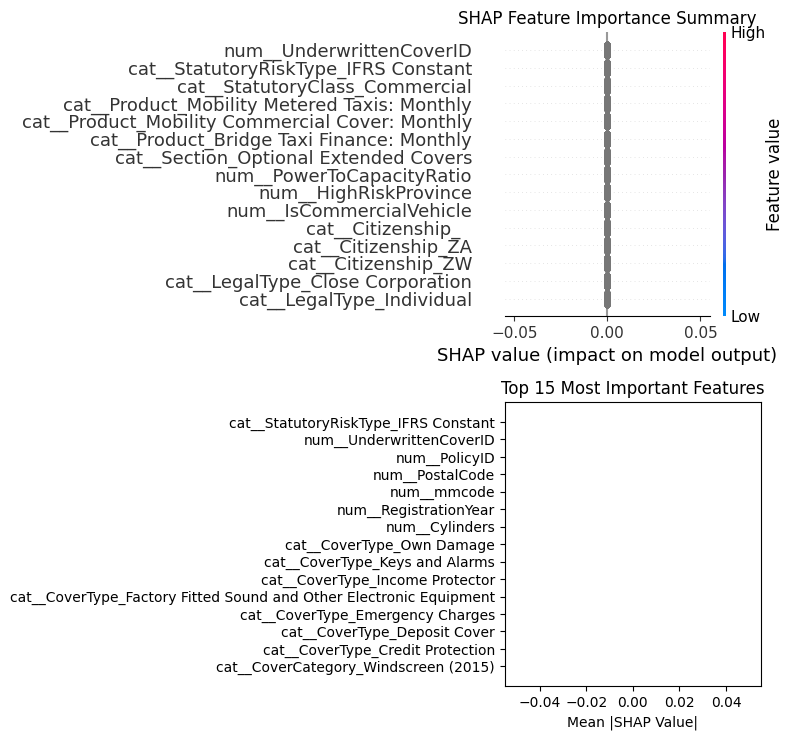


Top 15 Most Important Features:
1. cat__StatutoryRiskType_IFRS Constant: 0.0000
2. num__UnderwrittenCoverID: 0.0000
3. num__PolicyID: 0.0000
4. num__PostalCode: 0.0000
5. num__mmcode: 0.0000
6. num__RegistrationYear: 0.0000
7. num__Cylinders: 0.0000
8. cat__CoverType_Own Damage: 0.0000
9. cat__CoverType_Keys and Alarms: 0.0000
10. cat__CoverType_Income Protector: 0.0000
11. cat__CoverType_Factory Fitted Sound and Other Electronic Equipment: 0.0000
12. cat__CoverType_Emergency Charges: 0.0000
13. cat__CoverType_Deposit Cover: 0.0000
14. cat__CoverType_Credit Protection: 0.0000
15. cat__CoverCategory_Windscreen (2015): 0.0000


(array([[ 0.,  0., -0., ..., -0., -0., -0.],
        [ 0.,  0., -0., ..., -0., -0., -0.],
        [ 0.,  0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [ 0.,  0.,  0., ..., -0., -0., -0.],
        [-0., -0.,  0., ..., -0., -0., -0.]], shape=(558, 583)),
 array(['num__UnderwrittenCoverID', 'num__PolicyID', 'num__PostalCode',
        'num__mmcode', 'num__RegistrationYear', 'num__Cylinders',
        'num__cubiccapacity', 'num__kilowatts', 'num__NumberOfDoors',
        'num__CustomValueEstimate', 'num__SumInsured',
        'num__CalculatedPremiumPerTerm', 'num__TotalPremium',
        'num__VehicleAge', 'num__PremiumToSumInsuredRatio',
        'num__HasExcess', 'num__PowerToCapacityRatio',
        'num__HighRiskProvince', 'num__IsCommercialVehicle',
        'cat__Citizenship_  ', 'cat__Citizenship_ZA',
        'cat__Citizenship_ZW', 'cat__LegalType_Close Corporation',
        'cat__LegalType_Individual', 'cat__LegalType_Private company',
    

In [24]:
# Analyze feature importance for the best model
print("Analyzing feature importance for the best model...")



# Analyze feature importance
modeling.analyze_feature_importance(best_model, y_train, top_n=15)



In [27]:
modeling.generate_model_report(result)



MODEL PERFORMANCE COMPARISON REPORT
Model                RMSE         R-squared    MAE         
------------------------------------------------------------
linear_regression    0.0000       1.0000       0.0000      
random_forest        0.0000       1.0000       0.0000      
xgboost              0.0000       1.0000       0.0000      


In [28]:
# Use a subset for demonstration
sample_data = claims_data.sample(n=1000, random_state=42)
sample_prep = modeling.prepare_data(sample_data, 'CalculatedPremiumPerTerm', test_size=0.3, random_state=42, task_type='regression')
X_sample_train, X_sample_test, y_sample_train, y_sample_test = sample_prep

# Prepare for probability prediction
sample_prob_data = sample_data.copy()
sample_prob_data['HasClaim'] = (sample_prob_data['TotalClaims'] > 0).astype(int)
sample_prob_prep = modeling.prepare_data(sample_prob_data, 'HasClaim', test_size=0.3, random_state=42, task_type='classification')
X_prob_train, X_prob_test, y_prob_train, y_prob_test = sample_prob_prep

# Train sample models
sample_severity_models = modeling.train_models(X_sample_train, y_sample_train, task_type='regression')
sample_prob_models = modeling.train_models(X_prob_train, y_prob_train, task_type='classification')

# Get best sample models
_, best_sample_severity = modeling.evaluate_models(sample_severity_models, X_sample_test, y_sample_test, task_type='regression')
_, best_sample_prob = modeling.evaluate_models(sample_prob_models, X_prob_test, y_prob_test, task_type='classification')

# Calculate risk-based premiums
risk_premiums, claim_probs, claim_severities = modeling.predict_risk_based_premium(
    best_sample_prob, best_sample_severity, X_sample_test, expense_loading=0.1, profit_margin=0.15
)

Preparing data for regression task...
Original dataset shape: (1000, 52)
Engineering features...
Feature engineering complete. New shape: (1000, 61)
Handling missing values...
Missing values handled.
Numeric features: 20
Categorical features: 35
Training set shape: (700, 60)
Test set shape: (300, 60)
Preparing data for classification task...
Original dataset shape: (1000, 53)
Engineering features...
Feature engineering complete. New shape: (1000, 62)
Handling missing values...
Missing values handled.
Numeric features: 21
Categorical features: 35
Training set shape: (700, 61)
Test set shape: (300, 61)
Training models...
Built 3 models for regression task
Training linear_regression...


ValueError: A given column is not a column of the dataframe